In [152]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [188]:
df = pd.read_csv("drsummiya1.1.csv")

In [189]:
df.columns

Index(['Age', 'Education', 'Gender', 'Location', 'Marital Status',
       'Presence Psychiatric disorder', 'Stay', 'Treatment',
       'Previous Attempts', 'Source', 'Expired', 'StayInt', 'Target',
       'TargetNew', 'Toxic Intake'],
      dtype='object')

In [154]:
df['Education'] = df['Education'].str.capitalize() 

Text(0.5, 1, 'Urban')

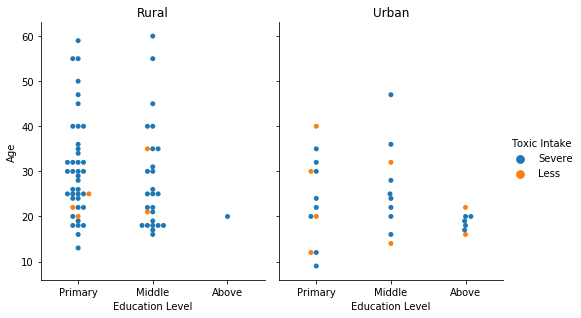

In [155]:
ax =  sns.catplot(x="Education", y="Age",hue="Toxic Intake", kind="swarm", col="Location",height=4.5, aspect=.8, data=df)
#ax.add_legend(title='Severity')
ax.set_axis_labels("Education Level", "Age")
axes = ax.axes.flatten()
axes[0].set_title("Rural")
axes[1].set_title("Urban")

Text(0.5, 1, 'Female')

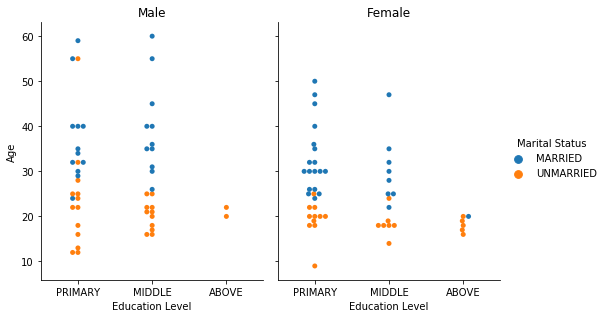

In [191]:
ax =  sns.catplot(x="Education", y="Age",hue="Marital Status", kind="swarm", col="Gender",height=4.5, aspect=.8, data=df)
#ax.add_legend(title='Severity')
ax.set_axis_labels("Education Level", "Age")
axes = ax.axes.flatten()
axes[0].set_title("Male")
axes[1].set_title("Female")

Text(0.5, 1, 'Female')

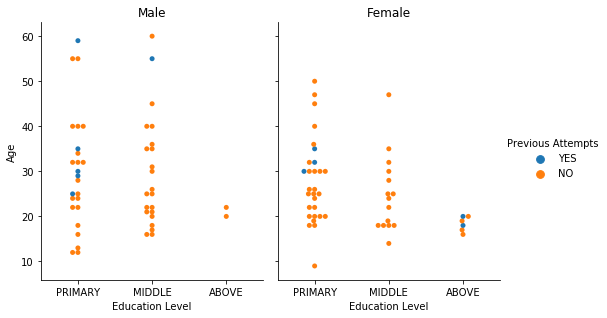

In [193]:
ax =  sns.catplot(x="Education", y="Age",hue="Previous Attempts", kind="swarm", col="Gender",height=4.5, aspect=.8, data=df)
#ax.add_legend(title='Severity')
ax.set_axis_labels("Education Level", "Age")
axes = ax.axes.flatten()
axes[0].set_title("Male")
axes[1].set_title("Female")

Text(0.5, 1, 'Un-Married')

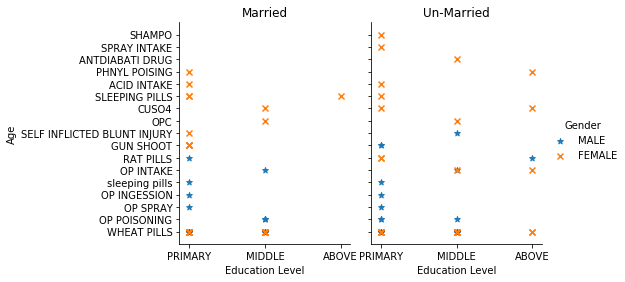

In [195]:

ax = sns.FacetGrid(df, col="Marital Status",  hue='Gender', height=4,  hue_kws={"marker": ['*','x']} )
ax.map(plt.scatter, "Education", "Source")
ax.add_legend()
ax.set_axis_labels("Education Level", "Age")
axes = ax.axes.flatten()
axes[0].set_title("Married")
axes[1].set_title("Un-Married")

In [157]:
df.columns

Index(['Age', 'Education', 'Gender', 'Location', 'Marital Status',
       'Presence Psychiatric disorder', 'Stay', 'Treatment',
       'Previous Attempts', 'Source', 'Expired', 'StayInt', 'Target',
       'TargetNew', 'Toxic Intake'],
      dtype='object')

In [158]:
df.columns = ['Age', 'Education', 'Gender', 'Location', 'Marital_Status',
       'Presence Psychiatric disorder', 'Stay', 'Treatment',
       'Previous_Attempts', 'Source', 'Expired', 'StayInt', 'Target',
       'TargetNew', 'Toxic_Intake']

In [159]:
df.columns

Index(['Age', 'Education', 'Gender', 'Location', 'Marital_Status',
       'Presence Psychiatric disorder', 'Stay', 'Treatment',
       'Previous_Attempts', 'Source', 'Expired', 'StayInt', 'Target',
       'TargetNew', 'Toxic_Intake'],
      dtype='object')

In [160]:
df.groupby('Gender').size()

Gender
FEMALE    50
MALE      49
dtype: int64

In [161]:
df['Gender'].value_counts(normalize=True) * 100

FEMALE    50.505051
MALE      49.494949
Name: Gender, dtype: float64

In [162]:
100. * df.Source.value_counts() / len(df.Source)

WHEAT PILLS                    53.535354
RAT PILLS                       6.060606
OP POISONING                    6.060606
CUSO4                           6.060606
OP INTAKE                       4.040404
GUN SHOOT                       2.020202
ACID INTAKE                     2.020202
OP SPRAY                        2.020202
ASPRINE                         1.010101
ZUSO4                           1.010101
SHAMPO                          1.010101
OP INGESSION                    1.010101
BLEECH INTAKE                   1.010101
SELF INFLICTED BLUNT INJURY     1.010101
SPRAY INTAKE                    1.010101
OPIOD                           1.010101
OPC                             1.010101
PAIN KILLERS                    1.010101
OP SPRAY+ INGESSION             1.010101
PHENYL                          1.010101
SLEEPING PILLS                  1.010101
ANTDIABATI DRUG                 1.010101
PHNYL POISING                   1.010101
sleeping pills                  1.010101
Name: Source, dt

In [163]:
100. * df.Toxic_Intake.value_counts() / len(df.Toxic_Intake)

Severe    86.868687
Less      13.131313
Name: Toxic_Intake, dtype: float64

In [164]:
100. * df.Education.value_counts() / len(df.Education)

Primary    54.545455
Middle     37.373737
Above       8.080808
Name: Education, dtype: float64

In [165]:
100. * df.Previous_Attempts.value_counts() / len(df.Previous_Attempts)

NO     88.888889
YES    11.111111
Name: Previous_Attempts, dtype: float64

In [166]:
100. * df.Marital_Status.value_counts() / len(df.Marital_Status)

MARRIED      50.505051
UNMARRIED    49.494949
Name: Marital_Status, dtype: float64

In [172]:
def processCategories(df):
    dummyEducation = pd.get_dummies(df['Education'], prefix='ed', drop_first=True)
    dummyGender    = pd.get_dummies(df['Gender'], prefix='gen', drop_first=True)
    dummyLocation  = pd.get_dummies(df['Location'], prefix='loc', drop_first=True)
    dummyMaritalStatus = pd.get_dummies(df['Marital_Status'], prefix='ms', drop_first=True)
    dummyPresencePsychiatricDisorder = pd.get_dummies(df['Presence Psychiatric disorder'], prefix='ppd', drop_first=True)
    dummyPreviousAttempts = pd.get_dummies(df['Previous_Attempts'], prefix='pa', drop_first=True)
    df.drop(['Target','TargetNew','StayInt','Expired','Source','Treatment','Stay','Education','Gender','Location','Marital_Status','Presence Psychiatric disorder','Previous_Attempts'], axis=1, inplace=True)
    return pd.concat([df,dummyEducation,dummyGender,dummyLocation,dummyMaritalStatus,dummyPresencePsychiatricDisorder,dummyPreviousAttempts], axis=1)
    

In [173]:
final = processCategories(df)

In [174]:
final

,Age,Toxic_Intake,ed_Middle,ed_Primary,gen_MALE,loc_URBAN,ms_UNMARRIED,ppd_YES,pa_YES
0,30,Severe,0,1,1,0,0,1,1
1,18,Severe,1,0,0,0,1,1,0
2,18,Severe,0,1,1,0,1,0,0
3,12,Severe,0,1,1,1,1,0,0
4,32,Severe,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
94,36,Severe,0,1,0,0,0,0,0
95,26,Severe,0,1,0,0,0,0,0
96,50,Severe,0,1,0,0,0,0,0
97,24,Severe,0,1,0,1,0,0,0


In [175]:
X = final.drop('Toxic_Intake',axis='columns')

In [176]:
X

,Age,ed_Middle,ed_Primary,gen_MALE,loc_URBAN,ms_UNMARRIED,ppd_YES,pa_YES
0,30,0,1,1,0,0,1,1
1,18,1,0,0,0,1,1,0
2,18,0,1,1,0,1,0,0
3,12,0,1,1,1,1,0,0
4,32,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
94,36,0,1,0,0,0,0,0
95,26,0,1,0,0,0,0,0
96,50,0,1,0,0,0,0,0
97,24,0,1,0,1,0,0,0


In [177]:
y = final.Toxic_Intake

In [178]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 70% training and 30% test

In [180]:
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [181]:
#print("Accuracy:",metrics.accuracy_score(y_test, Y_pred))

In [182]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)

/home/raza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [183]:
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)

In [184]:
gaussian = GaussianNB() 
gaussian.fit(X_train, y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

In [185]:
perceptron = Perceptron(max_iter=100)
perceptron.fit(X_train, y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)

In [186]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)

/home/raza/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [187]:
results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
             'Naive Bayes', 'Perceptron','SVM'],
    'Score': [acc_knn, acc_log, 
              acc_gaussian, acc_perceptron, 
              acc_linear_svc]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
91.30,SVM
88.41,KNN
88.41,Logistic Regression
85.51,Perceptron
34.78,Naive Bayes
